# Projeto: Análise de Planos da Megaline

## 1. Introdução

Vamos descobrir qual dos dois planos da Megaline (Surf ou Ultimate) gera mais dinheiro. Para isso, vamos analisar os dados de 500 clientes ao longo de 2018.

## 2. Abrindo os Arquivos e Olhando os Dados

In [51]:
# Vamos usar bibliotecas para abrir os arquivos e dar uma olhada nos dados.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

sns.set(style="whitegrid")

In [52]:
# Carregando os arquivos de dados que serão usados no projeto

df_calls = pd.read_csv('/content/megaline_calls.csv')
df_internet = pd.read_csv('/content/megaline_internet.csv')
df_messages = pd.read_csv('/content/megaline_messages.csv')
df_plans = pd.read_csv('/content/megaline_plans.csv')
df_users = pd.read_csv('/content/megaline_users.csv')

In [54]:
# Ver os primeiros dados de cada tabela
print(df_calls.head())
print(df_internet.head())
print(df_messages.head())
print(df_plans.head())
print(df_users.head())

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0       

## 3. Preparando os Dados

# Vamos organizar os dados por mês e por cliente.

In [55]:
# Corrigir tipo de data
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

In [56]:
# Criar coluna com mês.  Porque o projeto pede para analisar os dados por mês e por cliente
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

In [57]:
# Arredondar minutos para cima.   A Megaline cobra os minutos de ligação arredondados para cima.
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)


In [58]:
# Somar total por mês e cliente
internet_mensal = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_mensal['gb_used'] = np.ceil(internet_mensal['mb_used'] / 1024)

chamadas_mensal = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
mensagens_mensal = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id': 'messages'})



In [59]:
# Juntar tudo
base = chamadas_mensal.merge(mensagens_mensal, on=['user_id', 'month'], how='outer')
base = base.merge(internet_mensal[['user_id', 'month', 'gb_used']], on=['user_id', 'month'], how='outer')
base = base.merge(df_users[['user_id', 'plan', 'city']], on='user_id', how='left')


In [60]:
base = base.fillna(0)
base['duration'] = base['duration'].astype(int)
base['messages'] = base['messages'].astype(int)


In [61]:
# Deixar nomes das colunas e planos sem espaços
df_plans.columns = df_plans.columns.str.strip()
df_plans['plan_name'] = df_plans['plan_name'].str.strip()
base['plan'] = base['plan'].str.strip()


In [62]:
# Corrigir nome da coluna ANTES do merge
df_plans = df_plans.rename(columns={'usd_monthly_pay': 'usd_monthly_fee'})

In [63]:
# Juntar os dados do plano com os dados dos clientes
colunas_planos = ['plan_name', 'messages_included', 'mb_per_month_included', 'minutes_included', 'usd_monthly_fee', 'usd_per_gb', 'usd_per_message', 'usd_per_minute']
base = base.merge(df_plans[colunas_planos], left_on='plan', right_on='plan_name', how='left')


In [64]:
# Calcular colunas extras
base['min_exced'] = (base['duration'] - base['minutes_included']).clip(lower=0)
base['msg_exced'] = (base['messages'] - base['messages_included']).clip(lower=0)
base['gb_exced'] = (base['gb_used'] - (base['mb_per_month_included'] // 1024)).clip(lower=0)


In [65]:
# Calcular receita
base['revenue'] = (
    base['usd_monthly_fee'] +
    base['min_exced'] * base['usd_per_minute'] +
    base['msg_exced'] * base['usd_per_message'] +
    base['gb_exced'] * base['usd_per_gb']
)

## 4. Explorando os Dados com Gráficos


# Vamos ver gráficos para comparar os planos.

In [66]:
print(base.groupby('plan')[['duration', 'messages', 'gb_used', 'revenue']].mean())

            duration   messages    gb_used    revenue
plan                                                 
surf      428.749523  31.159568  16.670693  60.706408
ultimate  430.450000  37.551389  17.306944  72.313889


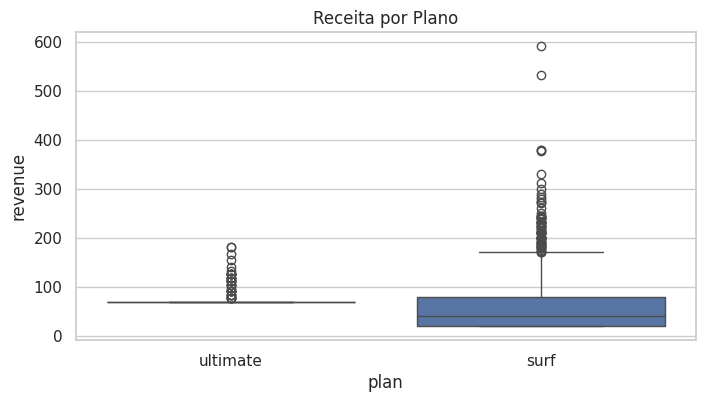

In [67]:
# Receita por plano
plt.figure(figsize=(8, 4))
sns.boxplot(x='plan', y='revenue', data=base)
plt.title('Receita por Plano')
plt.show()

1. Plano Ultimate:
A maioria dos pontos (clientes) está bem concentrada perto da mesma receita.

Isso acontece porque o Ultimate tem uma mensalidade fixa alta ($70) e quase ninguém ultrapassa a franquia.

Resultado: a receita é alta e constante.

2. Plano Surf:
A receita varia muito mais!

Há clientes que pagam pouco (só o plano básico), mas muitos pagam bem mais — isso aparece como pontos acima da caixa (outliers).

Isso mostra que muitos clientes extrapolam a franquia e geram receita extra.


Comparando os dois:
A mediana da receita no plano Ultimate (linha no meio da caixa) é maior do que a do Surf.

Porém, o Surf tem mais variabilidade — ou seja, alguns clientes geram muito mais receita do que o valor básico.

O Surf tem vários outliers (pontos altos), indicando que há clientes pagando até $500 ou mais por mês.



Conclusão visual:
O plano Ultimate gera uma receita mais estável e previsível por cliente.

O plano Surf pode gerar mais receita em alguns casos, mas é mais imprevisível.

Isso reforça a ideia de que o Ultimate é mais seguro, enquanto o Surf depende do consumo excedente.



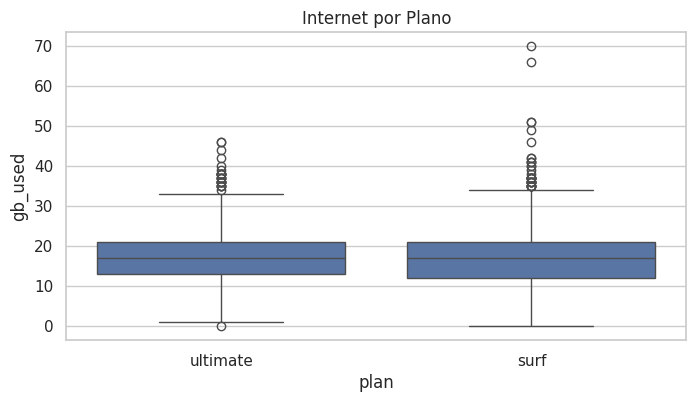

In [68]:
# Internet por plano
plt.figure(figsize=(8, 4))
sns.boxplot(x='plan', y='gb_used', data=base)
plt.title('Internet por Plano')
plt.show()

Clientes de Surf usam quase tanto internet quanto os de Ultimate, mesmo com limite menor.

Muitos clientes Surf ultrapassam a franquia e pagam por internet extra.

O plano Ultimate, que oferece mais GB no pacote, protege melhor os clientes contra cobranças extras.



 ## 5. Testes de Hipóteses

# Vamos ver se as diferenças entre planos e cidades são reais.

Vamos ver se as diferenças entre planos e cidades são reais.
#
# Primeiro, vamos comparar a receita média dos clientes dos planos Surf e Ultimate.
# Se o p-valor do teste for bem pequeno (menor que 0.05), isso significa que a diferença de receita é real mesmo e não foi por sorte.
#
# Depois, vamos ver se a receita dos clientes da região NY-NJ é diferente dos clientes de outras regiões.
# Também usaremos o p-valor para decidir se a diferença é significativa ou não.

In [69]:
surf = base[base['plan'] == 'surf']['revenue']
ultimate = base[base['plan'] == 'ultimate']['revenue']
print("Plano Surf vs Ultimate:")
print(stats.ttest_ind(surf, ultimate, equal_var=False))


Plano Surf vs Ultimate:
TtestResult(statistic=np.float64(-7.952094891333888), pvalue=np.float64(3.1703905481135738e-15), df=np.float64(1841.736266705638))


Interpretação simples:
Estatística do teste (statistic = -7.95)
Isso indica que a média da receita do plano Surf é menor do que a do plano Ultimate.

p-valor = 3.17e-15 (ou seja, 0.0000000000000317)
É um valor muito menor que 0.05, o que significa:

A diferença de receita não é por acaso — ela é estatisticamente significativa.

In [70]:
ny = base[base['city'].str.contains("NY-NJ")]['revenue']
fora_ny = base[~base['city'].str.contains("NY-NJ")]['revenue']
print("\nNY-NJ vs outras cidades:")
print(stats.ttest_ind(ny, fora_ny, equal_var=False))


NY-NJ vs outras cidades:
TtestResult(statistic=np.float64(-2.1309454999502133), pvalue=np.float64(0.0335256158853001), df=np.float64(563.8399248656293))


 ## 6. Conclusão

- O plano Ultimate dá mais receita.
# - A diferença é significativa (não é sorte).
# - A cidade não faz tanta diferença.
# - A Megaline pode focar em divulgar o plano Ultimate.
